In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sys
sys.path.append('..')

In [44]:
import cv2
from tqdm import tqdm

from lib.data import load_extracted_samples, load_extracted_sample
from lib.details_ocr import extract_lines_ocr, filter_detail_lines, split_detail_line
from lib.image_preprocessing import deskew_image
from lib.ocr import get_ocrs
from lib.util import display_image

In [45]:
samples = load_extracted_samples("only_ocr")
len(samples)

6294

In [46]:
# from lib.ocr import OCRParams, run_ocr_sample
# run_ocr_sample( load_extracted_sample("K37537400.pdf"), OCRParams(engine="paddleocr", deskew=True))

In [47]:
sample = load_extracted_sample("2023-04-24_5807.pdf")
ocr = get_ocrs(sample)["paddleocr_deskew"]

page_index = 0
page_ocr = ocr[page_index]
image_path = sample["images"][page_index]
image = cv2.imread(image_path)
image = deskew_image(image)

In [48]:
sample

{'filename': '2023-04-24_5807.pdf',
 'size': 1930713,
 'pages': 2,
 'text': '',
 'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/2023-04-24_5807.pdf/0.png',
  '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/2023-04-24_5807.pdf/1.png']}

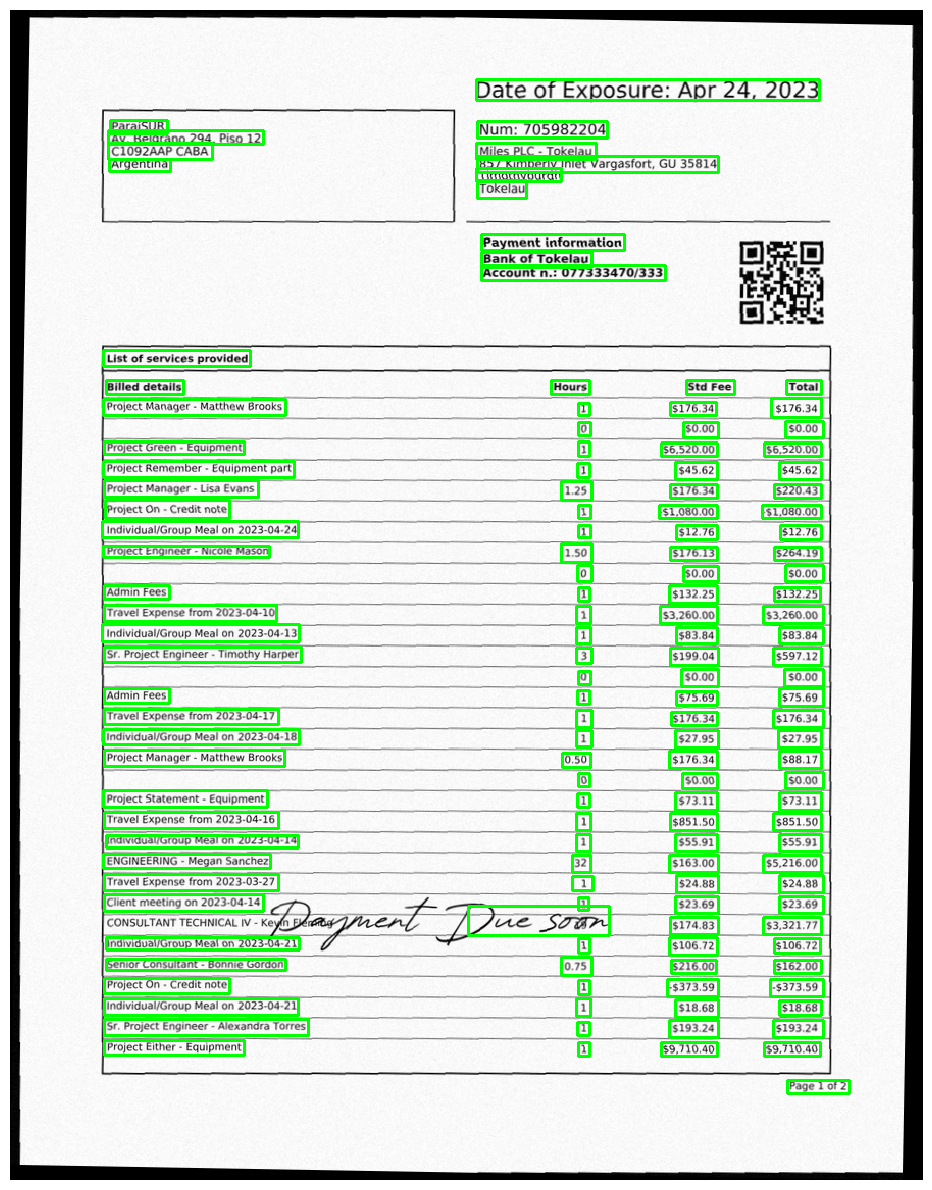

In [49]:
image_boxes = image.copy()

for box in page_ocr["boxes"]:
    cv2.rectangle(image_boxes, box["bounds"][0], box["bounds"][2], (0, 255, 0), 2)

display_image(image_boxes)

In [50]:
def display_lines(image, lines):
    img = image.copy()

    for boxes in lines:
        x_min = min(boxes, key=lambda k: k["bounds"][0][0])["bounds"][0][0]
        x_max = max(boxes, key=lambda k: k["bounds"][2][0])["bounds"][2][0]
        y_min = min(boxes, key=lambda k: k["bounds"][0][1])["bounds"][0][1]
        y_max = max(boxes, key=lambda k: k["bounds"][2][1])["bounds"][2][1]
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # type: ignore

    display_image(img)

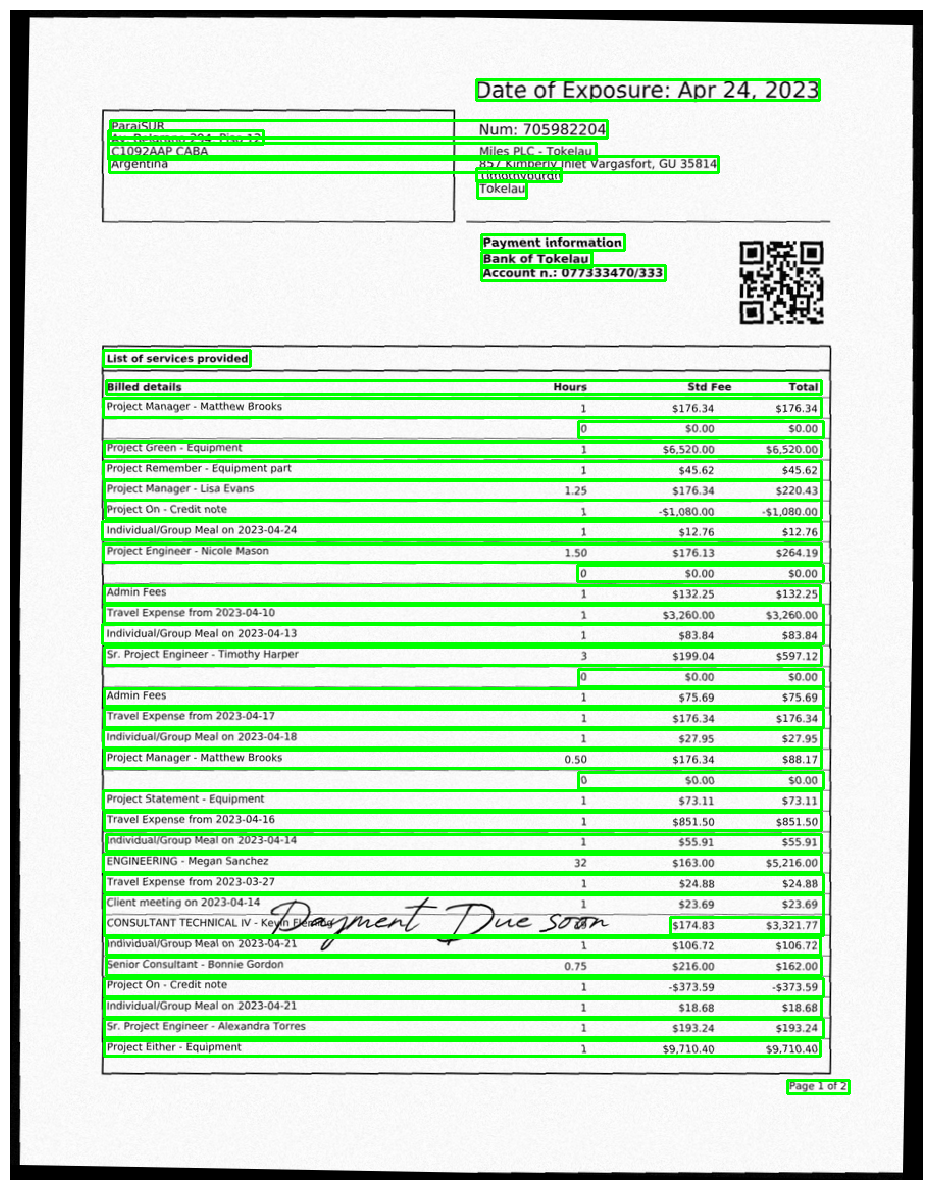

In [51]:
lines = extract_lines_ocr(page_ocr["boxes"])
display_lines(image, lines)

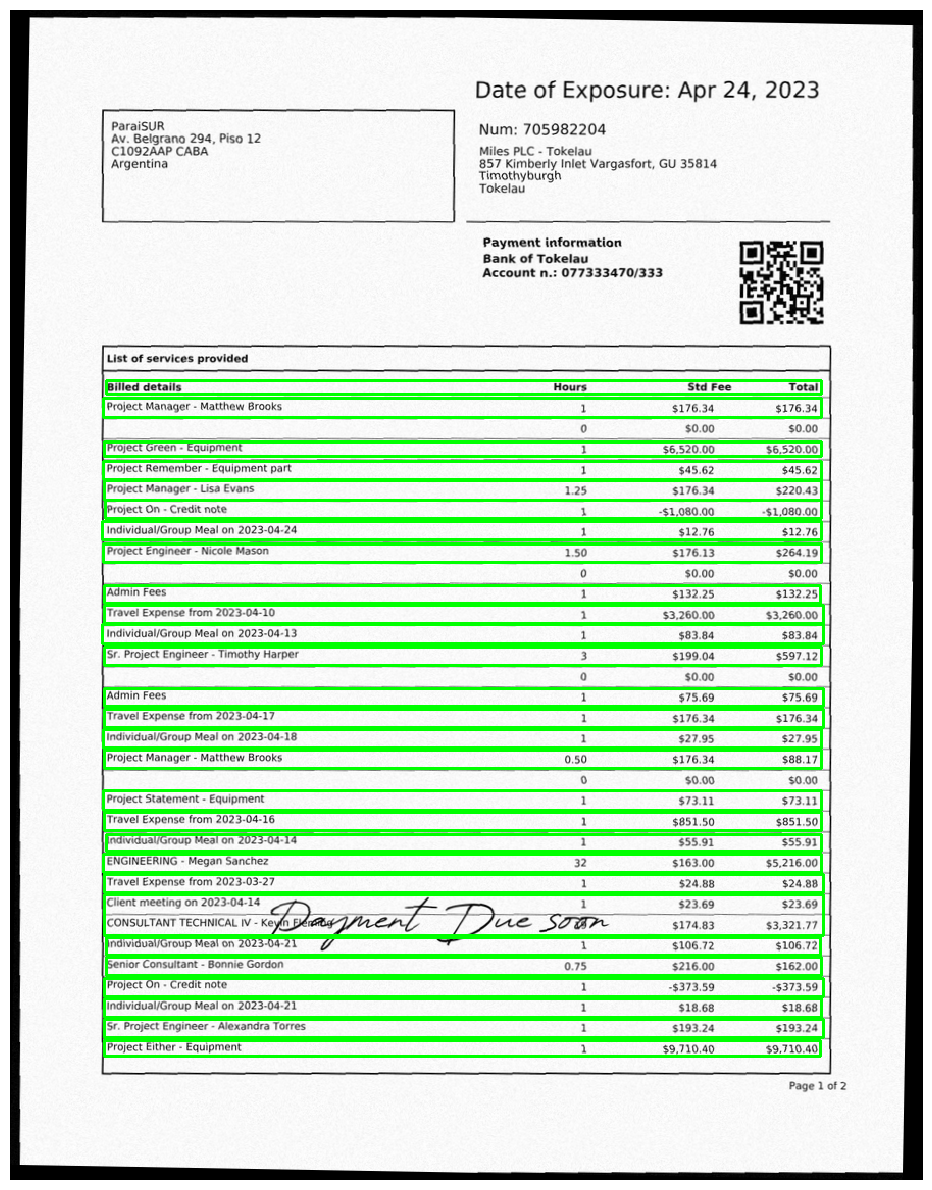

In [52]:
detail_lines = filter_detail_lines(lines)
display_lines(image, detail_lines)

In [53]:
[split_detail_line(line) for line in detail_lines]

[None,
 {'desc': 'Project Manager -Matthew Brooks 1 $176.34',
  'total': 176.34,
  'total_str': '$176.34'},
 {'desc': 'Project Green-Equipment 1 $6,520.00',
  'total': 6520.0,
  'total_str': '$6,520.00'},
 {'desc': 'Project Remember -Equipment part 1 $45.62',
  'total': 45.62,
  'total_str': '$45.62'},
 {'desc': 'Project Manager -Lisa Evans 1.25 $176.34',
  'total': 220.43,
  'total_str': '$220.43'},
 {'desc': 'Project On -Credit note 1 -$1,080.00',
  'total': -1080.0,
  'total_str': '-$1,080.00'},
 {'desc': 'Individual/Group Meal on 2023-04-24 1 $12.76',
  'total': 12.76,
  'total_str': '$12.76'},
 {'desc': 'Project Engineer-Nicole Mason 1.50 $176.13',
  'total': 264.19,
  'total_str': '$264.19'},
 {'desc': 'Admin Fees 1 $132.25', 'total': 132.25, 'total_str': '$132.25'},
 {'desc': 'Travel Expense from 2023-04-10 1 $3,260.00',
  'total': 3260.0,
  'total_str': '$3,260.00'},
 {'desc': 'Individual/Group Meal on 2023-04-13 1 $83.84',
  'total': 83.84,
  'total_str': '$83.84'},
 {'desc': 

In [54]:
asd

# calcular el % de None's que hay en promedio en los samples
none_avgs = []

for sample in tqdm(samples):
    ocrs = get_ocrs(sample)
    if "paddleocr_deskew" in ocrs:
        all_lines = []

        for page_ocr in ocrs["paddleocr_deskew"]:
            all_lines += extract_lines_ocr(page_ocr["boxes"])
        
        detail_lines = filter_detail_lines(all_lines)
        splitted_lines = [split_detail_line(line) for line in detail_lines]

        num_nones = sum([1 for line in splitted_lines if line is None])
        num_lines = len(splitted_lines)

        # print(sample, splitted_lines)
        none_avgs.append((sample, num_nones / num_lines))

NameError: name 'asd' is not defined

In [ ]:
# sort by avg
sorted(none_avgs, key=lambda x: -x[1])[:2]

[({'filename': 'Invoice (5213).pdf',
   'size': 1069162,
   'pages': 2,
   'text': '',
   'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Invoice (5213).pdf/0.png',
    '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Invoice (5213).pdf/1.png']},
  1.0),
 ({'filename': 'Email_Attachment_2023-03-20_6589.pdf',
   'size': 873801,
   'pages': 2,
   'text': '',
   'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Email_Attachment_2023-03-20_6589.pdf/0.png',
    '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Email_Attachment_2023-03-20_6589.pdf/1.png']},
  1.0)]

(array([1655., 2700., 1099.,  355.,  143.,   93.,   26.,   15.,   13.,
          12.,   11.,   17.,   18.,   19.,   15.,   19.,   12.,   12.,
          12.,   48.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

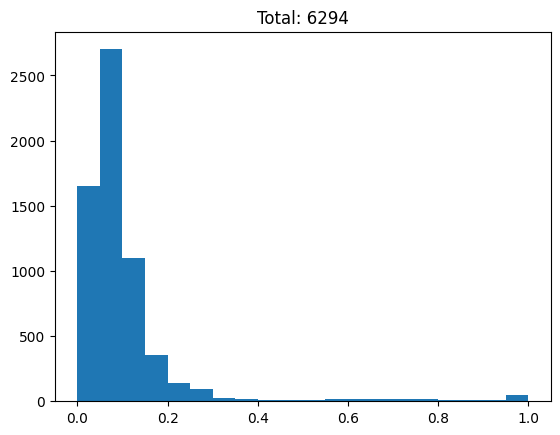

In [ ]:
# plot avg distribution
import matplotlib.pyplot as plt

plt.title("Total: " + str(len(none_avgs)))
plt.hist([x[1] for x in none_avgs], bins=20, range=(0, 1))